<a href="https://colab.research.google.com/github/Swarno-Coder/ImgSegUsing_U-Net/blob/master/ImageSegmentation_Using_U_Net_Architechture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=da13629f55153e3658ba3e4d0027e702f4bb107961aca7f5189f5eeae1c40684
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=beba6431f14c9ec7227b604a94ec35abc6827f48d02e6aea60179fbc0457af1d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 20.48 MiB/s, done.
Resolving deltas: 100% (3/3), done.


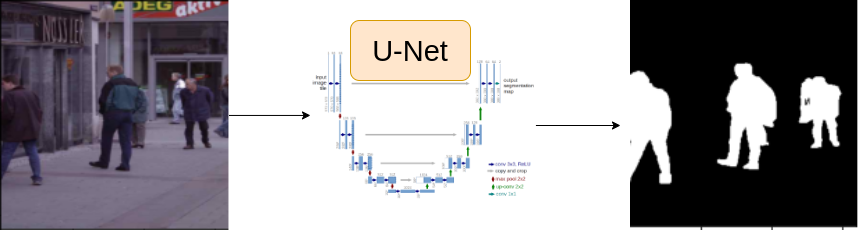

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master/')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cuda:0"

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [6]:
import pandas as pd
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
import cv2

image_number = 6

row = df.iloc[image_number]

image = cv2.imread(row.images)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(row.masks, cv2.IMREAD_GRAYSCALE)

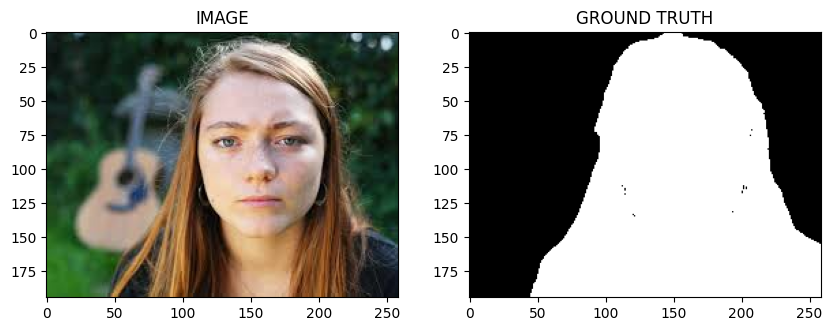

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
traindf, testdf = train_test_split(df, test_size=0.3, random_state=42)

# Task 3 : Augmentation Functions

See albumentation documentation : [Click Here](https://albumentations.ai/docs/)

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],is_check_shapes=False)

def get_test_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augs):
    self.df = df
    self.augs = augs
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image = cv2.imread(row.images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(row.masks, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augs:
      data = self.augs(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [14]:
trainset = SegmentationDataset(traindf, get_train_augs())
validset = SegmentationDataset(testdf, get_test_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 203
Size of Validset : 87


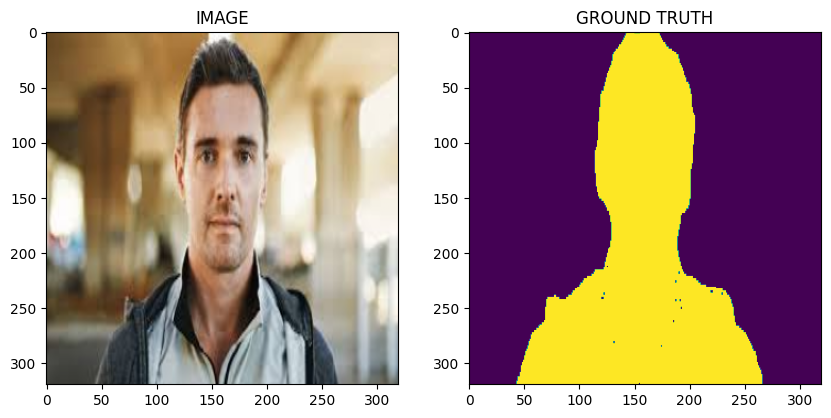

In [16]:
idx = 3
img, msk = trainset[idx]
#helper.show_image(img, msk)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(img.permute(1,2,0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(msk.permute(1,2,0))


In [17]:
msk.shape

torch.Size([1, 320, 320])

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f"no. of batches in trainloader: {len(trainloader)}")
print(f"no. of batches in validloader: {len(validloader)}")

no. of batches in trainloader: 13
no. of batches in validloader: 6


In [21]:
for image,mask in trainloader:
  break
print(f"batch shape of image: {image.shape}")
print(f"batch shape of mask: {mask.shape}")

batch shape of image: torch.Size([16, 3, 320, 320])
batch shape of mask: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None,
    )
  def forward(self, image, mask = None):
    logits = self.arc(image)

    if mask != None:
      loss1 = DiceLoss(mode="binary")(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 79.3MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [28]:
def train_fn(dataLoader, model, optimizers):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataLoader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizers.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizers.step()

    total_loss += loss.item()

  return total_loss / len(dataLoader)


In [29]:
def eval_fn(dataLoader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataLoader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(dataLoader)

# Task 8 : Train Model

In [27]:
optimizers = torch.optim.Adam(model.parameters(), lr=LR)

In [31]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model=model,optimizers=optimizers)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss
  print(f"Epoch: {i+1} Train_Loss: {train_loss} Valid_Loss: {valid_loss}")


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


SAVED-MODEL
Epoch: 1 Train_Loss: 0.20481898578313681 Valid_Loss: 0.20678252478440604


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


Epoch: 2 Train_Loss: 0.22216284045806298 Valid_Loss: 0.30519476532936096


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


Epoch: 3 Train_Loss: 0.18209109398034903 Valid_Loss: 0.29426855593919754


100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


SAVED-MODEL
Epoch: 4 Train_Loss: 0.16070696482291588 Valid_Loss: 0.20053511361281076


100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


Epoch: 5 Train_Loss: 0.1511853583730184 Valid_Loss: 0.2539859935641289


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


Epoch: 6 Train_Loss: 0.17717371021325773 Valid_Loss: 0.2384415790438652


100%|██████████| 6/6 [00:01<00:00,  4.64it/s]


SAVED-MODEL
Epoch: 7 Train_Loss: 0.1534800357543505 Valid_Loss: 0.1986916959285736


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


SAVED-MODEL
Epoch: 8 Train_Loss: 0.13571116442863757 Valid_Loss: 0.17976088325182596


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


Epoch: 9 Train_Loss: 0.12700837277449095 Valid_Loss: 0.2020943115154902


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


SAVED-MODEL
Epoch: 10 Train_Loss: 0.11401822532598789 Valid_Loss: 0.15240351607402167


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


Epoch: 11 Train_Loss: 0.1451132257397358 Valid_Loss: 0.1733035147190094


100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


Epoch: 12 Train_Loss: 0.16728985481537306 Valid_Loss: 0.36870483060677844


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Epoch: 13 Train_Loss: 0.19714703124303085 Valid_Loss: 0.2037945811947187


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Epoch: 14 Train_Loss: 0.15740206092596054 Valid_Loss: 0.19525504857301712


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


Epoch: 15 Train_Loss: 0.14260304375336721 Valid_Loss: 0.19591166079044342


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


Epoch: 16 Train_Loss: 0.15302520990371704 Valid_Loss: 0.28641893217960995


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


Epoch: 17 Train_Loss: 0.1224119348021654 Valid_Loss: 0.20084095373749733


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


Epoch: 18 Train_Loss: 0.12617768118014702 Valid_Loss: 0.24624053140481314


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


Epoch: 19 Train_Loss: 0.12343948850264916 Valid_Loss: 0.1641164223353068


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


Epoch: 20 Train_Loss: 0.10387468395324853 Valid_Loss: 0.17699744800726572


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


SAVED-MODEL
Epoch: 21 Train_Loss: 0.09915234950872567 Valid_Loss: 0.1502829703191916


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Epoch: 22 Train_Loss: 0.10300725068037327 Valid_Loss: 0.17159479608138403


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


Epoch: 23 Train_Loss: 0.0869553920168143 Valid_Loss: 0.16812447210152945


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


Epoch: 24 Train_Loss: 0.08809946534725335 Valid_Loss: 0.20306183646122614


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]

Epoch: 25 Train_Loss: 0.07542315010841076 Valid_Loss: 0.17388342941800752


# Task 9 : Inference

In [34]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


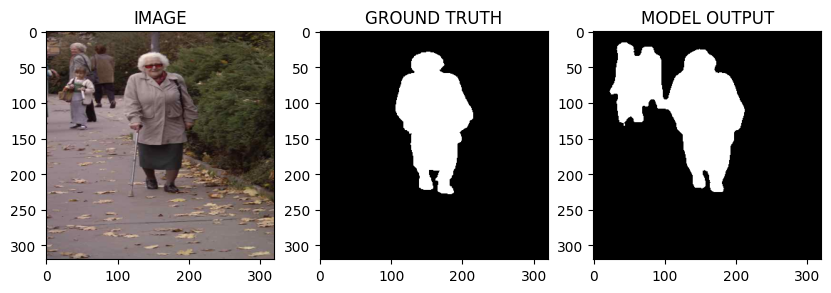

In [35]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

###Visit my LinkedIn for more info [Swarnodip Nag](https://www.linkedin.com/in/swarnodip--nag/)